# Two Rectangles Detection

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Data Generation

In [2]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_rect_size, max_rect_size, size = 2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x + w, y:y + h] = 1.
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 2, 4))

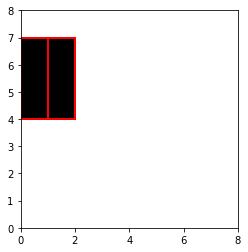

In [3]:
i = 0
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r', fc = 'none'))

## Preprocessing

In [4]:
# Reshape and normalize the data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), 6.548095399239173e-17, 1.0000000000000002)

In [5]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 8), 0.2813375, 0.1752005328723346)

## Train Test Split

In [6]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## CNN Model

In [75]:
# Build the model.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
        ])
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 18,696
Trainable params: 18,696
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [8]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating function

In [9]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [10]:
# Since the model won't know which box to predict first, we have to flip bboxes during training.
# In here, flipping bboxes means switching the data of two bboxes.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 

num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1,
              callbacks = [ModelCheckpoint('Two_Rectangles_model.h5',
                                           monitor = 'val_accuracy',
                                           save_best_only = True)])
    model_test = load_model('Two_Rectangles_model.h5')
    pred_y = model.predict(train_X)
    
    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + distance(pred_bboxes[4:], exp_bboxes[4:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + distance(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        if mse_flipped < mse:  # you can also use iou or dist here
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            mses_epoch[i, epoch] = mse_flipped / 2.
            ious_epoch[i, epoch] = iou_flipped / 2.
            dists_epoch[i, epoch] = dist_flipped / 2.
        else:
            mses_epoch[i, epoch] = mse / 2.
            ious_epoch[i, epoch] = iou / 2.
            dists_epoch[i, epoch] = dist / 2.
            
    print('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))

Epoch:  0
1250/1250 [==============================] - 1s 1ms/step - loss: 0.0452 - accuracy: 0.2779 - val_loss: 0.0184 - val_accuracy: 0.3519
Flipped 19101.0 training samples (47.7525 %)
Mean IOU: 0.17005186476229364
Mean dist: 0.20217401524631265
Mean mse: 0.00834285103411052
Epoch:  1
1250/1250 [==============================] - 1s 883us/step - loss: 0.0167 - accuracy: 0.4533 - val_loss: 0.0190 - val_accuracy: 0.3699
Flipped 8446.0 training samples (21.115000000000002 %)
Mean IOU: 0.22284583843369254
Mean dist: 0.16366880337625794
Mean mse: 0.005987206328219746
Epoch:  2
1250/1250 [==============================] - 1s 875us/step - loss: 0.0127 - accuracy: 0.5441 - val_loss: 0.0214 - val_accuracy: 0.3780
Flipped 4458.0 training samples (11.145 %)
Mean IOU: 0.29993396517027243
Mean dist: 0.13030961032047397
Mean mse: 0.004360096361651221
Epoch:  3
1250/1250 [==============================] - 1s 1ms/step - loss: 0.0105 - accuracy: 0.5911 - val_loss: 0.0224 - val_accuracy: 0.3724
Flippe

1250/1250 [==============================] - 1s 876us/step - loss: 0.0059 - accuracy: 0.6995 - val_loss: 0.0255 - val_accuracy: 0.3935
Flipped 738.0 training samples (1.8450000000000002 %)
Mean IOU: 0.4940274990293467
Mean dist: 0.06641751371406965
Mean mse: 0.0017022500729946479
Epoch:  30
1250/1250 [==============================] - 1s 877us/step - loss: 0.0058 - accuracy: 0.7006 - val_loss: 0.0263 - val_accuracy: 0.3899
Flipped 496.0 training samples (1.24 %)
Mean IOU: 0.4946681467247728
Mean dist: 0.06559355897676669
Mean mse: 0.0016836343150201131
Epoch:  31
1250/1250 [==============================] - 1s 1ms/step - loss: 0.0059 - accuracy: 0.6964 - val_loss: 0.0263 - val_accuracy: 0.3938
Flipped 457.0 training samples (1.1424999999999998 %)
Mean IOU: 0.48605567755965073
Mean dist: 0.06746304588762853
Mean mse: 0.0016870240785164603
Epoch:  32
1250/1250 [==============================] - 1s 979us/step - loss: 0.0058 - accuracy: 0.7015 - val_loss: 0.0261 - val_accuracy: 0.3925
Flip

## Flipping Track

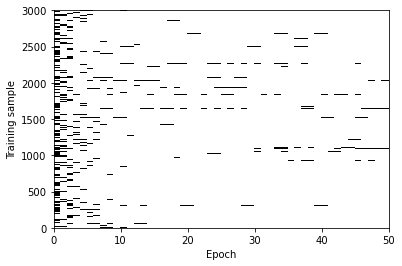

In [74]:
# Show flippings for a few training samples.
'''Differences between pcolor() and pcolormesh(): 
   pcolormesh() is more specialized for the given purpose and thus is faster. It should almost always be preferred.'''
plt.pcolormesh(flipped[:3000, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('two-rectangles_flips.png', dpi = 100)
plt.show()

## Metrics Track

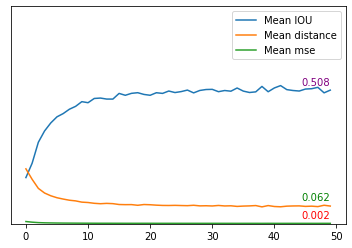

In [62]:
# Plot metrics on the training data. 
mean_ious_epoch = np.mean(ious_epoch, axis = 0)
mean_dists_epoch = np.mean(dists_epoch, axis = 0)
mean_mses_epoch = np.mean(mses_epoch, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')
# horizontalalignment = 'right': make the annotation text aligns with the right side
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'purple')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

# Hide y tick
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.legend()
plt.ylim(0, 0.8)
plt.savefig('training_metrics.png', dpi = 100)

## Denormalize Data

In [66]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 2, 4)

## Visualized Results

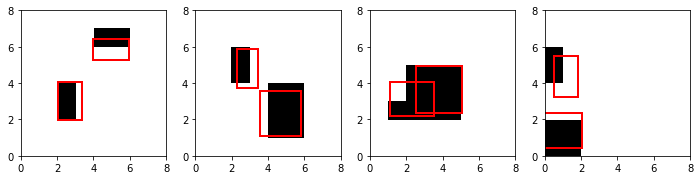

In [71]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize = (12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r', fc = 'none'))

plt.savefig('two-rectangles_with-flipping.png', dpi = 100)